# DreamBooth 

In [14]:
from huggingface_hub import notebook_login

notebook_login()

Creating our own dataset

```python
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="your_folder_of_images")
# Push to Hub
dataset.push_to_hub("dreambooth-hackathon-images")
dataset = dataset['train']
```

Once you've created your dataset, you can download it by using the `load_dataset()` function as follows:

In [2]:
from datasets import load_dataset

dataset_id = "google/dreambooth"  # CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, "backpack",split="train")
dataset

Dataset({
    features: ['image'],
    num_rows: 6
})

Now that we have our dataset, let's define a helper function to view a few of the images:

In [8]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 4
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

If this looks good, you can move onto the next step - creating a PyTorch dataset for training with DreamBooth.

## Step 3: Create a training dataset

In [3]:
name_of_your_concept = "wfgt"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
type_of_thing = "backpack"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of wfgt backpack


In [4]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [5]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

{'instance_images': tensor([[[ 0.5529,  0.5529,  0.5529,  ...,  0.4196,  0.4118,  0.4118],
          [ 0.5451,  0.5529,  0.5529,  ...,  0.4196,  0.4118,  0.4118],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.4196,  0.4118,  0.4118],
          ...,
          [-0.2471, -0.2471, -0.2549,  ...,  0.3255,  0.3255,  0.3255],
          [-0.2627, -0.2627, -0.2706,  ...,  0.3255,  0.3255,  0.3255],
          [-0.2627, -0.2706, -0.2706,  ...,  0.3176,  0.3176,  0.3176]],
 
         [[ 0.5843,  0.5843,  0.5843,  ...,  0.4588,  0.4510,  0.4510],
          [ 0.5765,  0.5843,  0.5843,  ...,  0.4588,  0.4510,  0.4510],
          [ 0.5765,  0.5765,  0.5765,  ...,  0.4588,  0.4510,  0.4510],
          ...,
          [-0.0275, -0.0275, -0.0275,  ...,  0.3961,  0.3961,  0.3961],
          [-0.0353, -0.0353, -0.0431,  ...,  0.3961,  0.3961,  0.3961],
          [-0.0353, -0.0431, -0.0431,  ...,  0.3882,  0.3882,  0.3882]],
 
         [[ 0.6078,  0.6078,  0.6078,  ...,  0.4902,  0.4824,  0.4824],
         

In [15]:
len(train_dataset)

6

In [12]:
import torch


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

## Step 5: Load the components of the Stable Diffusion pipeline

We nearly have all the pieces ready for training! As you saw in the Unit 3 notebook on Stable Diffusion, the pipeline is composed of several models:

* A text encoder that converts the prompts into text embeddings. Here we're using CLIP since it's the encoder used to train Stable Diffusion v1-4.
* A VAE or variational autoencoder that converts the images to compressed representations (i.e., latents) and decompresses them at inference time.
* A UNet that applies the denoising operation on the latent of the VAE.

We can load all these components using the 🤗 Diffusers and 🤗 Transformers libraries as follows:

In [6]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

2025-09-04 16:54:31.336781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757004871.359902     165 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757004871.366705     165 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Step 6: Fine-tune the model

In [7]:
learning_rate = 2e-06
max_train_steps = 400

Next, let's wrap the other hyperparameters we need in a `Namespace` object to make it easier to configure the training run:

In [8]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # Set this to True to lower the memory usage
    use_8bit_adam=True,  # Use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # Where to save the pipeline
)

The final step is to define a `training_function()` function that wraps the training logic and can be passed to 🤗 Accelerate to handle training on 1 or more GPUs. If this is the first time you're using 🤗 Accelerate, check out this video to get a quick overview of what it can do:

In [32]:
from IPython.display import YouTubeVideo
YouTubeVideo("s7dy8QRgjJ0")

The details should look familiar to what we saw in Units 1 & 2 when we trained our own diffusion models from scratch:

In [9]:
pip install bitsandbytes


Note: you may need to restart the kernel to use updated packages.


In [10]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # Only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using the trained modules and save it
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

Now that we have the function defined, let's train it! Depending on the size of your dataset and type of GPU, this can take anywhere from 5 minutes to 1 hour to run:

In [13]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

Launching training on one GPU.


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline and saving to my-dreambooth...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

If you're running on a single GPU, you can free up some memory for the next section by copying the code below into a new cell and running it. For multi-GPU machines, 🤗 Accelerate doesn't allow _any_ cell to directly access the GPU with `torch.cuda`, so we don't recommend using this trick in those cases:

```python
with torch.no_grad():
    torch.cuda.empty_cache()
```

In [15]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Step 7: Run inference and inspect generations

Now that we've trained the model, let's generate some images with it to see how it fares! First we'll load the pipeline from the output directory we save the model to:

In [16]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Next, let's generate a few images. The `prompt` variable will later be used to set the default on the Hugging Face Hub widget, so experiment a bit to find a good one. You might also want to try creating elaborate prompts with [CLIP Interrogator](https://huggingface.co/spaces/pharma/CLIP-Interrogator):

In [18]:
from PIL import Image


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [21]:
type_of_thing

'backpack'

In [22]:
# Pick a funny prompt here and it will be used as the widget's default 
# when we push to the Hub in the next section
prompt = f"a photo of {name_of_your_concept} {type_of_thing}"

# Tune the guidance to control how closely the generations follow the prompt
# Values between 7-11 usually work best
guidance_scale = 7

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

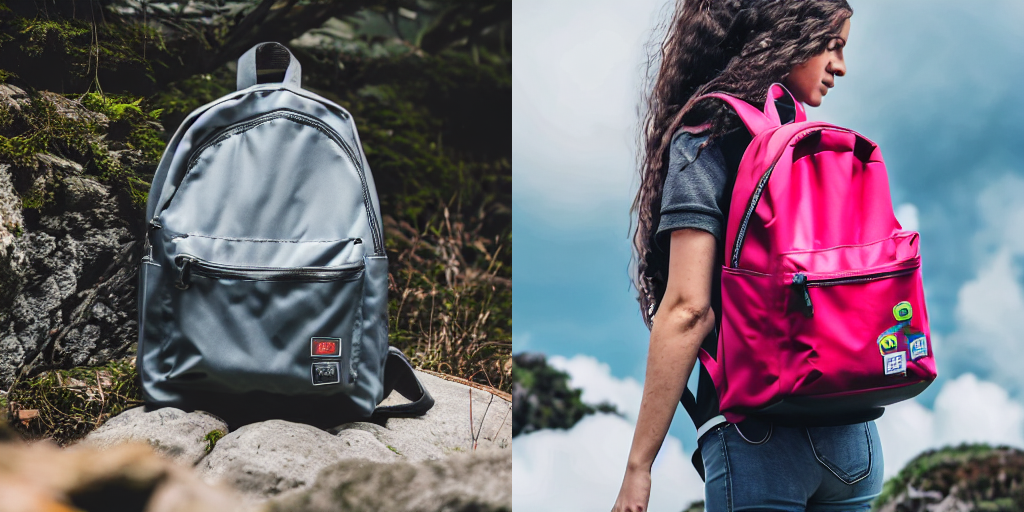

In [23]:
image_grid(all_images, 1, num_cols)

## Step 8: Push your model to the Hub

If you're happy with you model, the final step is to push it to the Hub and view it on the [DreamBooth Leaderboard](https://huggingface.co/spaces/dreambooth-hackathon/leaderboard)!

First, you'll need to define a name for your model repo. By default, we use the unique identifier and class name, but feel free to change this if you want: 

In [24]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f"{name_of_your_concept}-{type_of_thing}"

Next, add a brief description on the type of model you've trained or any other information you'd like to share:

In [26]:
# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on `{type_of_thing}` images.
"""

Finally, run the cell below to create a repo on the Hub and push all our files with a nice model card to boot:

In [29]:
theme = "backpacks"

In [30]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
widget:
- text: {prompt}
---



## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-68b9c95b-73499ffb5c75828b24a9b1e3;e3053f99-a74a-4f46-930b-eca2df6d256d)

You already created this model repo